## Importing libraries :

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import itertools
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import wordcloud
%matplotlib inline
plt.style.use('fivethirtyeight')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ahari\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\ahari\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


## Loading the Dataset :

In [2]:
data = pd.read_excel('Online Retail.xlsx', dtype={'StockCode':str})
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [3]:
data.shape

(541909, 8)

## Data Preprocessing :

In [4]:
# Checking for null values.
info = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,1454.000000,0.0,0.0,0.0,135080.000000,0.0
% Null values,0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


> Since we dont have CustomerID for 25% of points we will remove them as we cannot give them any arbitrary ID.

In [5]:
# Removing null values
data.dropna(axis=0, subset = ['CustomerID'], inplace=True)
info = pd.DataFrame(data=data.isnull().sum()).T.rename(index={0:'Null values'})
info = info.append(pd.DataFrame(data=data.isnull().sum()/data.shape[0] * 100).T.rename(index={0:'% Null values'}))
info

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
% Null values,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
# Checking for Duplicates :
data.duplicated().sum()

5225

In [7]:
# Removing duplicate entries :
data.drop_duplicates(inplace=True)
data.duplicated().sum()

0

## Exploratory Data Analysis :

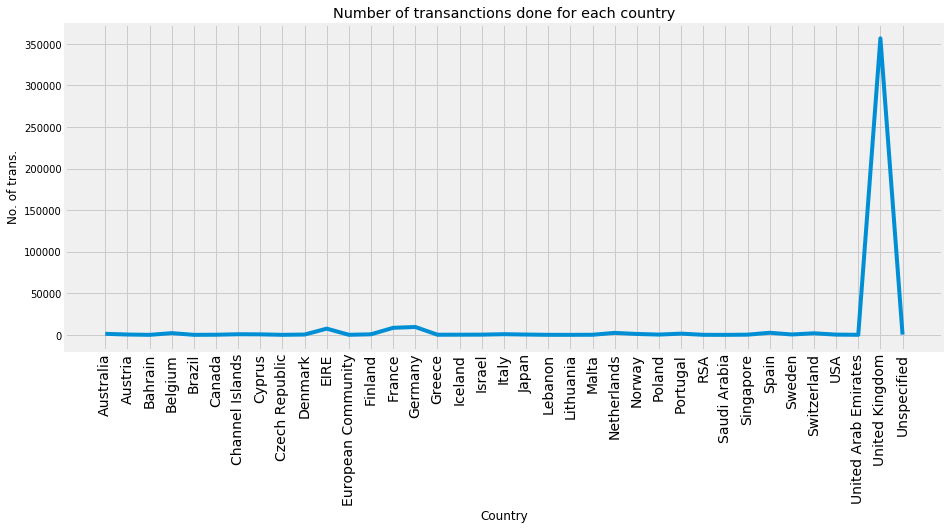

In [8]:
plt.figure(figsize=(14,6))
plt.plot(data.groupby(['Country']).groups.keys(), data.groupby(['Country'])['CustomerID'].count())
plt.xticks(rotation = 90, fontsize = 14)
plt.title("Number of transanctions done for each country")
plt.ylabel("No. of trans.")
plt.xlabel("Country")
plt.show()

In [9]:
info = pd.DataFrame(data = data.groupby(['Country'])['InvoiceNo'].nunique(), index=data.groupby(['Country']).groups.keys()).T
info

,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceNo,69,19,2,119,1,6,33,20,5,21,...,1,2,10,105,46,71,7,3,19857,8


** Conclusions **
1. UK has done most of the transanctions. (19857)
2. Least amount of transanctions were made by countries like Brazil, RSA etc. (only 1)

In [10]:
# StockCode Feature ->
# We will see how many different products were sold in the year data was collected.
print(len(data['StockCode'].value_counts()))

3684


In [11]:
# Transanction feature
# We will see how many different transanctions were done.
print(len(data['InvoiceNo'].value_counts()))

22190


In [12]:
# Transanction feature
# We will see how many different Customers are there.
print(len(data['CustomerID'].value_counts()))

4372


In [13]:
pd.DataFrame({'products':len(data['StockCode'].value_counts()),
              'transanctions':len(data['InvoiceNo'].value_counts()),
              'Customers':len(data['CustomerID'].value_counts())},
             index = ['Quantity'])

,products,transanctions,Customers
Quantity,3684,22190,4372


> There are 22k transanctions but only 4k customers with 3.5k products. It seems that some orders were placed then cancelled or the customers bought items multiple times or multiple items were bought in a single transanction.

##### Checking the number of items bought in a single transanctions :

In [14]:
df = data.groupby(['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate'].count()
df = df.rename(columns = {'InvoiceDate':'Number of products'})
df[:10].sort_values('CustomerID')

,CustomerID,InvoiceNo,Number of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


> There are customers who purchase only 1 item per transanction and others who purchase many items per transanction.
Also there are some orders which were cancelled they are marked with 'C' in the beginning.

##### Counting number of cancelled transanctions :

In [15]:
df['orders cancelled'] = df['InvoiceNo'].apply(lambda x: int('C' in str(x)))
df.head()

,CustomerID,InvoiceNo,Number of products,orders cancelled
0,12346.0,541431,1,0
1,12346.0,C541433,1,1
2,12347.0,537626,31,0
3,12347.0,542237,29,0
4,12347.0,549222,24,0


In [16]:
# Printing number of orders cancelled ->
print("Number of orders cancelled {}/{} ({:.2f}%)".format(df['orders cancelled'].sum(), df.shape[0], df['orders cancelled'].sum()/ df.shape[0] * 100))

Number of orders cancelled 3654/22190 (16.47%)


##### Handling Cancelled Values :

In [17]:
# Looking at cancelled transanctions in original data.
data.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland


> We see that for every order that has to be cancelled a new transanction has to be sarted with different invoiceno, with negative quantity and every other description is same.
We can use this to remove the cancelled orders.

##### Checking for discounted products :

In [18]:
df = data[data['Description'] == 'Discount']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom


> So there are some discounted transanctions too but they appear to be cancelled.

##### Checking whether every order that has been cancelled has a counterpart :

In [19]:
df = data[(data['Quantity']<0) & (data['Description']!='Discount')][['CustomerID','Quantity','StockCode','Description','UnitPrice']]
df.head()

,CustomerID,Quantity,StockCode,Description,UnitPrice
154,15311.0,-1,35004C,SET OF 3 COLOURED FLYING DUCKS,4.65
235,17548.0,-12,22556,PLASTERS IN TIN CIRCUS PARADE,1.65
236,17548.0,-24,21984,PACK OF 12 PINK PAISLEY TISSUES,0.29
237,17548.0,-24,21983,PACK OF 12 BLUE PAISLEY TISSUES,0.29
238,17548.0,-24,21980,PACK OF 12 RED RETROSPOT TISSUES,0.29


In [20]:
for index, col in df.iterrows():
    if data[(data['CustomerID'] == col[0]) & (data['Quantity'] == -col[1]) & (data['Description'] == col[2])].shape[0] == 0:
        print(index, df.loc[index])
        print("There are some transanctions for which counterpart does not exist")
        break

154 CustomerID                               15311
Quantity                                    -1
StockCode                               35004C
Description    SET OF 3 COLOURED  FLYING DUCKS
UnitPrice                                 4.65
Name: 154, dtype: object
There are some transanctions for which counterpart does not exist


We found out that there are some orders for which counterpart do not exist.
<br>
Reasons could be because some orders were made before the date the dataset is given from or that some orders were cancelled with exactly same counterpart or some are just errors maybe.

Removing cancelled orders :

In [21]:
df_cleaned = data.copy(deep=True)
df_cleaned['QuatityCancelled'] = 0
entry_to_remove = []; doubtfull_entry = []

for index, col in data.iterrows():
    if(col['Quantity'] > 0)or(col['Description']=='Discount'):continue
    df_test = data[(data['CustomerID']==col['CustomerID'])&(data['StockCode']==col['StockCode'])&
                   (data['InvoiceDate']<col['InvoiceDate'])&(data['Quantity']>0)].copy()
    
    # Order cancelled without counterpart, these are doubtful as they maybe errors or maybe orders were placed before data given
    if(df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    
    # Cancellation with single counterpart
    elif(df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)
        
    # Various counterpart exists for orders
    elif(df_test.shape[0] > 1):
        df_test.sort_index(axis = 0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']:continue
            df_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [22]:
print("Entry to remove {}".format(len(entry_to_remove)))
print("Doubtfull Entry {}".format(len(doubtfull_entry)))

Entry to remove 7521
Doubtfull Entry 1226


In [23]:
# Deleting these entries :
df_cleaned.drop(entry_to_remove, axis=0, inplace=True)
df_cleaned.drop(doubtfull_entry, axis=0, inplace=True)

##### We will now see the StockCode feature especially the discounted items:

In [24]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex = True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [25]:
for code in list_special_codes:
    print("{:<17} -> {:<35}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].values[0]))

POST              -> POSTAGE                            
D                 -> Discount                           
C2                -> CARRIAGE                           
M                 -> Manual                             
BANK CHARGES      -> Bank Charges                       
PADS              -> PADS TO MATCH ALL CUSHIONS         
DOT               -> DOTCOM POSTAGE                     


In [26]:
df_cleaned['QuantityCancelled'] = np.nan_to_num(df_cleaned['QuantityCancelled'])
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuatityCancelled,QuantityCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0,0.0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0,0.0


> We see that the same transanction is duplicated for every different item in the dataset. Like above invoice number 536365 the user probably purchased many different items and each have been given a row as shown. We will need to merge these so we will add the totalprice feature for each row.

##### Getting total data feature :

In [27]:
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCancelled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuatityCancelled,QuantityCancelled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,0,74215.0,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347.0,Iceland,0,0.0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347.0,Iceland,0,0.0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,0.0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347.0,Iceland,0,0.0,35.7


##### Now we sum the individual orders and group them on the basis of invoice number to remove the problem of duplicate rows for same order :

In [28]:
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347.0,537626,711.79,2010-12-07 14:57:00.000001024
2,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,2011-04-07 10:42:59.999999232
4,12347.0,556201,382.52,2011-06-09 13:01:00.000000256
5,12347.0,562032,584.91,2011-08-02 08:48:00.000000000
6,12347.0,573511,1294.32,2011-10-31 12:25:00.000001280


##### Plotting the purchases made :

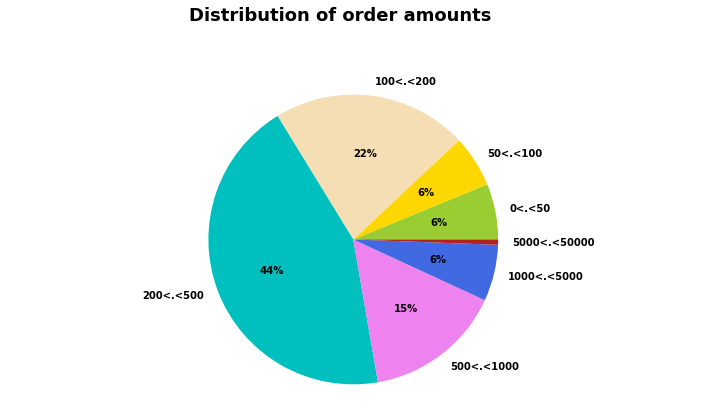

In [29]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i,price in enumerate(price_range):
    if i==0:continue
    val = basket_price[(basket_price['Basket Price'] < price)&
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
    
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ["{}<.<{}".format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha = 'center', fontsize = 18)
plt.show()

##### Analyzing product Description :

In [30]:
is_noun = lambda pos:pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne = 'Description'):
    import nltk
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots = dict()
    keywords_select = dict()
    category_keys = []
    count_keywords = dict()
    icount = 0
    
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
        
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)
            
            category_keys.append(clef)
            keywords_select[s] = clef
        
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
            
    print("Number of keywords in the variable '{}': {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [31]:
df_produits = pd.DataFrame(data['Description'].unique()).rename(columns = {0:"Description"})

In [32]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Number of keywords in the variable 'Description': 1484


In [33]:
# Plotting keywords vs frequency graph :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    list_products.append([word, v])

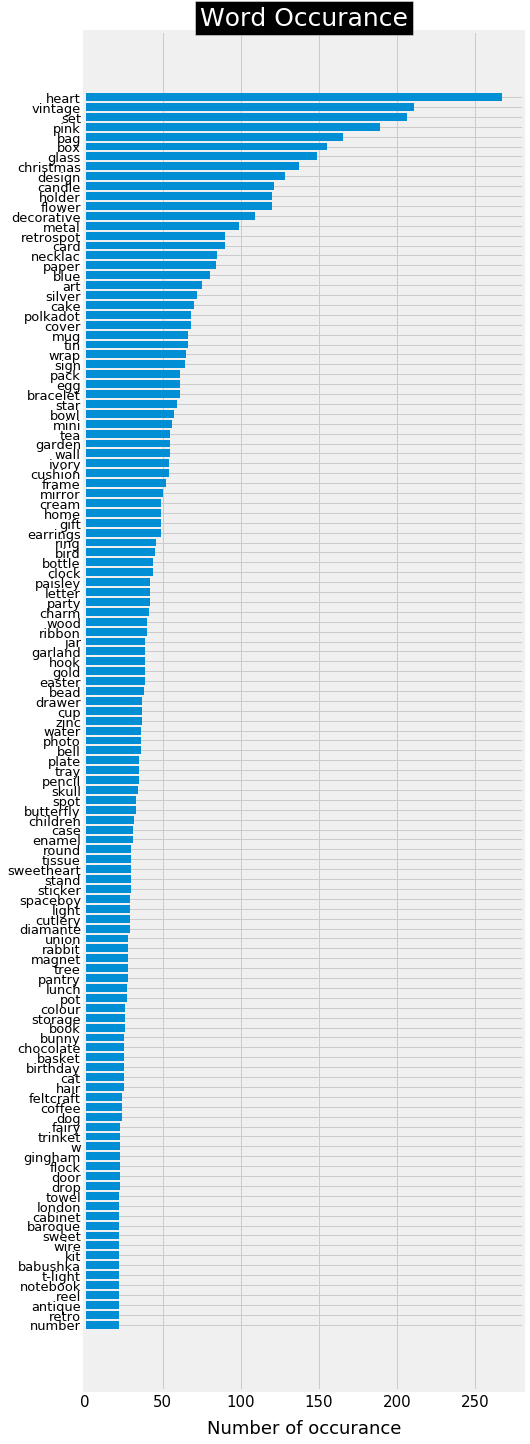

In [34]:
liste = sorted(list_products, key = lambda x:x[1], reverse=True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurance", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Word Occurance", bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
plt.show()

In [35]:
# Preserving important words :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word)<3 or v<13: continue
    list_products.append([word, v])
    
list_products.sort(key = lambda x:x[1], reverse=True)
print("Number of preserved words : ", len(list_products))

Number of preserved words :  193


##### Descrining every product in terms of words present in the description :
1. We will only use the preserved words, this is just like Binary Bag of Words<br>
2. We need to convert this into a product matrix with products as rows and different words as columns. A cell contains a 1 if a particular product has that word in its description else it contains 0.
3. We will use this matrix to categorize the products.
4. We will add a mean price feature so that the groups are balanced.

In [36]:
threshold = [0, 1, 2, 3, 5, 10]

# Getting the description.
liste_produits = df_cleaned['Description'].unique()

# Creating the product and word matrix.
X = pd.DataFrame()
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), liste_produits))
    

label_col = []
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i], threshold[i+1])
        
    label_col.append(col)
    X.loc[:, col] = 0
    
for i, prod in enumerate(liste_produits):
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    
    while prix > threshold[j]:
        j += 1
        if j == len(threshold):
            break
    X.loc[i, label_col[j-1]] = 1

In [37]:
print("{:<8} {:<20} \n".format('range', 'number of products') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

range    number of products   
--------------------
0<.<1       964                 
1<.<2       1009                
2<.<3       673                 
3<.<5       606                 
5<.<10      470                 
.>10        156                 


### Clustering :
1. KMEANS.

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [39]:
matrix = X.as_matrix()

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [40]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.10071681758064248
For n_clusters :  4 The average silhouette_score is :  0.12609893747265383
For n_clusters :  5 The average silhouette_score is :  0.1466257603527048
For n_clusters :  6 The average silhouette_score is :  0.1449025743560329
For n_clusters :  7 The average silhouette_score is :  0.14273276548911748
For n_clusters :  8 The average silhouette_score is :  0.14824674883472747
For n_clusters :  9 The average silhouette_score is :  0.15339317242258876


In [41]:
# Choosing number of clusters as 5:
# Trying Improving the silhouette_score :
n_clusters = 5
sil_avg = -1
while sil_avg < 0.145:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  5 The average silhouette_score is :  0.14631355248870398


In [42]:
# Printing number of elements in each cluster :
pd.Series(clusters).value_counts()

4    1009
0     964
2     829
1     606
3     470
dtype: int64

#### Analyzing the 5 clusters :

In [43]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    import matplotlib as mpl
    mpl.rc('patch', edgecolor = 'dimgray', linewidth = 1)
    
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhoutte_values = sample_silhouette_values[clusters == i]
        ith_cluster_silhoutte_values.sort()
        size_cluster_i = ith_cluster_silhoutte_values.shape[0]
        y_upper = y_lower + size_cluster_i
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhoutte_values, alpha = 0.8)
        
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color = 'red', fontweight = 'bold',
                 bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle = 'round, pad = 0.3'))
        
        y_lower = y_upper + 10

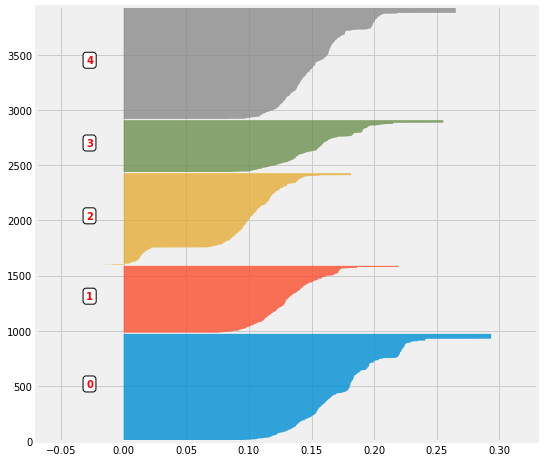

In [44]:
# Plotting the intra cluster silhouette distances.
from sklearn.metrics import silhouette_samples
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

##### Analysis using wordcloud:
> Checking which words are most common in the clusters.

In [45]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurance) in list_products]

occurance = [dict() for _ in range(n_clusters)]

In [46]:
# Creating data for printing word cloud.
for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurance[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))

In [47]:
# Code for printing word cloud.
from random import randint
import random
def random_color_func(word=None, font_size=None, position=None,orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

In [48]:
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4, 2, increment)
    words = dict()
    trunc_occurances = liste[0:150]
    for s in trunc_occurances:
        words[s[0]] = s[1]
        
    wc = wordcloud.WordCloud(width=1000,height=400, background_color='lightgrey', max_words=1628,relative_scaling=1,
                             color_func = random_color_func, normalize_plurals=False)
    wc.generate_from_frequencies(words)
    ax1.imshow(wc, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster n{}'.format(increment-1))

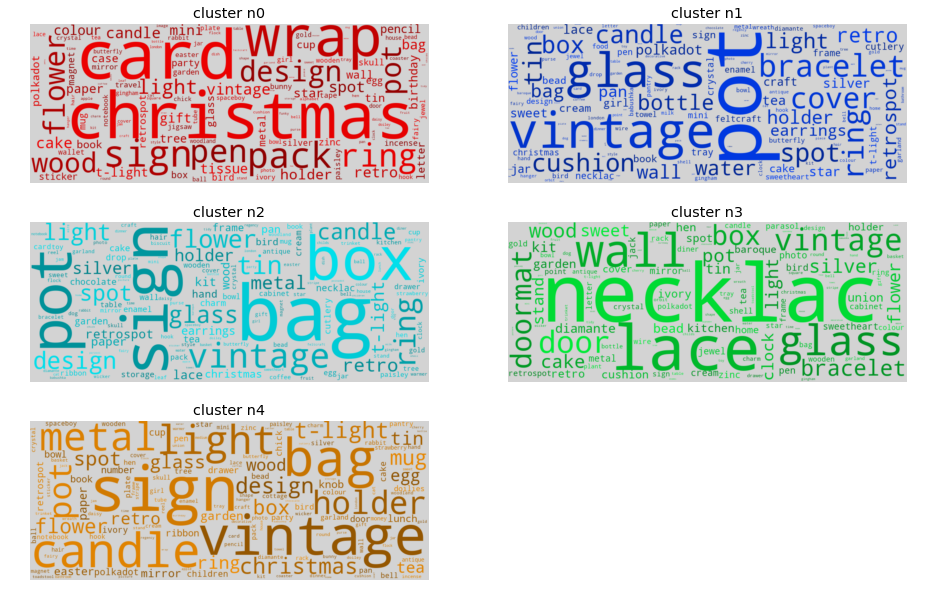

In [49]:
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurance[i]
    tone = color[i]
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1)

** Conclusions **
1. Cluster number two contains all the items related to decoration and gifts.
2. Cluster number 4 contains luxury items.
3. Words like Vintage are common to most of the clusters.

## Dimensionality Reduction:
> PCA

In [50]:
from sklearn.decomposition import PCA

In [51]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

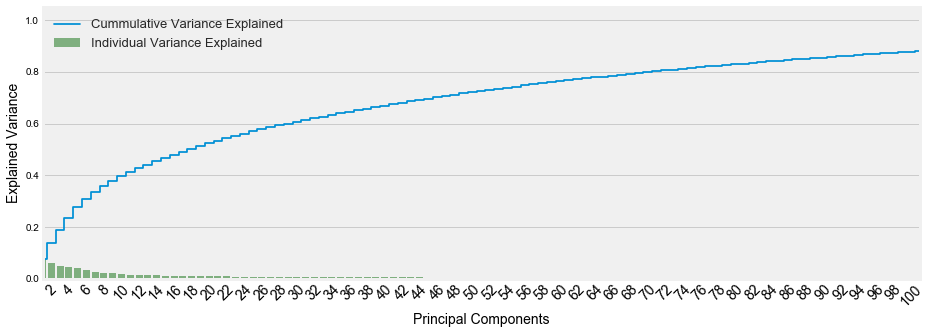

In [52]:
# Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 100)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

** We need more than 100 Principal Components to explain more than 90 % of the variance. **
<br>

## Generating Customer Segments/Categories :
1. We will use the already generated product categories and create a new feature which tells to which category the product belongs to.

In [53]:
corresp = dict()
for key, val in zip(liste_produits, clusters):
    corresp[key] = val
    
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description', 'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2
1,536365,WHITE METAL LANTERN,1
2,536365,CREAM CUPID HEARTS COAT HANGER,1
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1
5,536365,SET 7 BABUSHKA NESTING BOXES,3
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1
7,536366,HAND WARMER UNION JACK,2
8,536366,HAND WARMER RED POLKA DOT,4
9,536367,ASSORTED COLOUR BIRD ORNAMENT,4


In [54]:
# Creating 5 new features that will contain the amount in a single transanction on different categories of product.
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCancelled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
    
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,2,0.0,0.00,15.3,0.0,0.00
1,536365,WHITE METAL LANTERN,1,0.0,20.34,0.0,0.0,0.00
2,536365,CREAM CUPID HEARTS COAT HANGER,1,0.0,22.00,0.0,0.0,0.00
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1,0.0,20.34,0.0,0.0,0.00
4,536365,RED WOOLLY HOTTIE WHITE HEART.,1,0.0,20.34,0.0,0.0,0.00
5,536365,SET 7 BABUSHKA NESTING BOXES,3,0.0,0.00,0.0,15.3,0.00
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1,0.0,25.50,0.0,0.0,0.00
7,536366,HAND WARMER UNION JACK,2,0.0,0.00,11.1,0.0,0.00
8,536366,HAND WARMER RED POLKA DOT,4,0.0,0.00,0.0,0.0,11.10
9,536367,ASSORTED COLOUR BIRD ORNAMENT,4,0.0,0.00,0.0,0.0,54.08


##### A single order is split into multiple entries we will basket them :

In [55]:
# sum of purchases by user and order.
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})

# percentage spent on each product category 
for i in range(5):
    col = "categ_{}".format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)[col].sum()
    basket_price.loc[:, col] = temp

# Dates of the order.
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# Selecting entries with basket price > 0.
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347.0,537626,711.79,23.40,293.35,83.40,124.44,187.2,2010-12-07 14:57:00.000001024
2,12347.0,542237,475.39,84.34,169.20,91.35,0.00,130.5,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,81.00,115.00,109.35,0.00,330.9,2011-04-07 10:42:59.999999232
4,12347.0,556201,382.52,41.40,168.76,78.06,19.90,74.4,2011-06-09 13:01:00.000000256
5,12347.0,562032,584.91,61.30,158.16,157.95,97.80,109.7,2011-08-02 08:48:00.000000000


In [56]:
basket_price['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [57]:
basket_price['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

##### Time Based Splitting :

In [67]:
import datetime
#print(basket_price['InvoiceDate'] < datetime.datetime(2011, 10, 1))
set_entrainment = basket_price[basket_price['InvoiceDate'] < datetime.datetime(2011, 10, 1)]
set_test = basket_price[basket_price['InvoiceDate'] >= datetime.datetime(2011, 10, 1)]
basket_price = set_entrainment.copy(deep = True)

##### Grouping Orders :
> We will get info about every customer on how much do they purchase, total number of orders. etc

In [68]:
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100
    
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transanctions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,5,382.52,711.79,558.172000,2790.86,10.442659,32.408290,18.636191,8.676179,29.836681
1,12348.0,4,227.44,892.80,449.310000,1797.24,38.016069,0.000000,20.030714,0.000000,41.953217
2,12350.0,1,334.40,334.40,334.400000,334.40,11.692584,0.000000,39.862440,0.000000,48.444976
3,12352.0,6,144.35,840.30,345.663333,2073.98,0.491808,15.711338,56.603728,14.301006,12.892120
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,0.000000,64.606742,22.359551,13.033708


In [69]:
# Generating two new variables - days since first puchase and days since last purchase.
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transanctions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transanctions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']

In [70]:
transanctions_per_user[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,5,382.52,711.79,558.172000,2790.86,10.442659,32.408290,18.636191,8.676179,29.836681,59,297
1,12348.0,4,227.44,892.80,449.310000,1797.24,38.016069,0.000000,20.030714,0.000000,41.953217,5,288
2,12350.0,1,334.40,334.40,334.400000,334.40,11.692584,0.000000,39.862440,0.000000,48.444976,240,240
3,12352.0,6,144.35,840.30,345.663333,2073.98,0.491808,15.711338,56.603728,14.301006,12.892120,2,226
4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,0.000000,64.606742,22.359551,13.033708,134,134


##### We need to focus on customers who only placed one order, our objective is to target these customers in a way to retains them.

In [71]:
n1 = transanctions_per_user[transanctions_per_user['count'] == 1].shape[0]
n2 = transanctions_per_user.shape[0]
print("No. of Customers with single purchase : {:<2}/{:<5} ({:<2.2f}%)".format(n1, n2, n1/n2*100))

No. of Customers with single purchase : 1445/3608  (40.05%)


##### Building Customer Segments :

In [72]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transanctions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].as_matrix()

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
print("Variable Mean Values: \n" + 90*'-' + '\n', scaler.mean_)
scaled_matrix = scaler.transform(matrix)

Variable Mean Values: 
------------------------------------------------------------------------------------------
 [  3.62305987 259.93189634 556.26687999 377.06036244  13.98907929
  16.37327913  28.73795868  15.67936332  25.22916919]


In [74]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

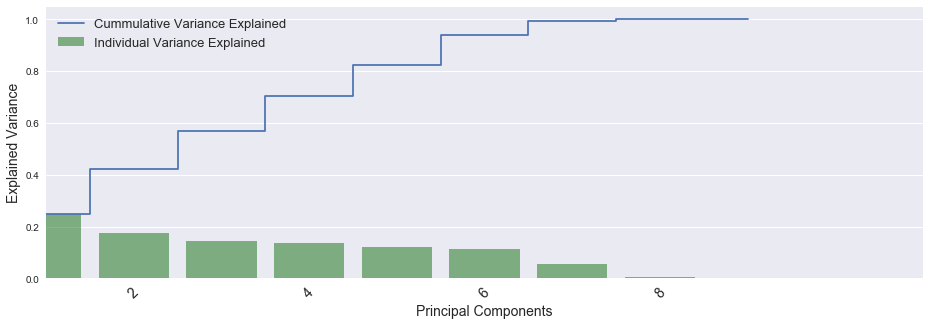

In [75]:
# Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 10)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

In [76]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 21):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.15105510924758267
For n_clusters :  4 The average silhouette_score is :  0.16253394816100777
For n_clusters :  5 The average silhouette_score is :  0.16827055263316495
For n_clusters :  6 The average silhouette_score is :  0.1773606332251356
For n_clusters :  7 The average silhouette_score is :  0.1924845281246002
For n_clusters :  8 The average silhouette_score is :  0.2027893766715767
For n_clusters :  9 The average silhouette_score is :  0.20326770665409324
For n_clusters :  10 The average silhouette_score is :  0.20973753541020387
For n_clusters :  11 The average silhouette_score is :  0.19201524248592852
For n_clusters :  12 The average silhouette_score is :  0.1910219174140292
For n_clusters :  13 The average silhouette_score is :  0.18968642130231286
For n_clusters :  14 The average silhouette_score is :  0.19152005900872188
For n_clusters :  15 The average silhouette_score is :  0.19305370713721126
For n_clusters :  16 Th

In [77]:
# Choosing number of clusters as 10:
# Trying Improving the silhouette_score :
n_clusters = 10
sil_avg = -1
while sil_avg < 0.208:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  10 The average silhouette_score is :  0.20909979945465265


In [78]:
n_clusters = 10
kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print("Silhouette Score : {:<.3f}".format(silhouette_avg))

Silhouette Score : 0.209


In [79]:
# Looking at clusters :
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns=['Number of Clients']).T

,8,1,0,9,6,3,4,7,5,2
Number of Clients,1511,515,444,351,292,244,207,21,12,11


> There is a large difference in cluster segments, We will analyze these clusters further.

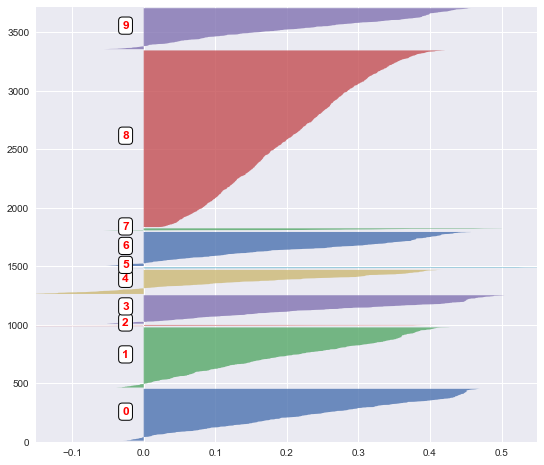

In [80]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

From this above graph we can rest assured that all the clusters are disjoint

##### Now we need to learn the habits of the customers to do that we will add the variables that define a cluster to which each customer belong:

In [81]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [82]:
merged_df = pd.DataFrame()
for i in range(n_clusters):
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    test = test.T.set_index('cluster', drop = True)
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    merged_df = pd.concat([merged_df, test])
    
merged_df.drop('CustomerID', axis = 1, inplace = True)
print('Number of customers : ', merged_df['size'].sum())

merged_df = merged_df.sort_values('sum')

Number of customers :  3608


In [83]:
# Reorganizing the content of the dataframe.
liste_index = []
for i in range(5):
    column = 'categ_{}'.format(i)
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])
    
liste_index_reordered = liste_index
liste_index_reordered += [s for s in merged_df.index if s not in liste_index]

merged_df = merged_df.reindex(index = liste_index_reordered)
merged_df = merged_df.reset_index(drop = False)
merged_df.head()

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
0,3.0,2.176230,192.802746,314.448074,245.659509,571.000041,56.365156,6.332537,13.527422,5.517872,18.257012,98.786885,166.331967,244
1,6.0,2.150685,202.993390,352.709110,265.393823,693.747979,6.632377,51.318551,17.687859,10.843403,13.570856,110.784247,170.609589,292
2,0.0,2.547297,206.457905,359.130360,275.651832,781.226441,5.813132,7.306340,64.942594,9.993004,11.944930,115.587838,192.495495,444
3,9.0,2.683761,193.706524,319.453276,249.020677,712.040570,5.232151,13.105839,18.032947,52.210922,11.434217,119.547009,192.230769,351
4,1.0,2.475728,217.660874,334.574856,272.950346,708.796080,13.442536,8.200535,17.060574,5.839529,55.459715,102.875728,174.990291,515


##### Saving the selected customer dataframe and above dataframe to csv so that we do not need to do all this again :

In [84]:
selected_customers.to_csv("selected_customers.csv")

In [85]:
merged_df.to_csv("merged_df.csv")

## Classifying the Customers :

In [86]:
selected_customers = pd.read_csv('selected_customers.csv')
merged_df = pd.read_csv('merged_df.csv')

##### Defining Helper Functions :

In [87]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
class Class_Fit(object):
    def __init__(self, clf, params = None):
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)
    
    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} %".format(100 * accuracy_score(Y, self.predictions)))

In [88]:
selected_customers.head()

,Unnamed: 0,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,cluster
0,0,12347.0,5,382.52,711.79,558.172000,2790.86,10.442659,32.408290,18.636191,8.676179,29.836681,59,297,8
1,1,12348.0,4,227.44,892.80,449.310000,1797.24,38.016069,0.000000,20.030714,0.000000,41.953217,5,288,1
2,2,12350.0,1,334.40,334.40,334.400000,334.40,11.692584,0.000000,39.862440,0.000000,48.444976,240,240,1
3,3,12352.0,6,144.35,840.30,345.663333,2073.98,0.491808,15.711338,56.603728,14.301006,12.892120,2,226,0
4,4,12353.0,1,89.00,89.00,89.000000,89.00,0.000000,0.000000,64.606742,22.359551,13.033708,134,134,0


In [89]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
X = selected_customers[columns]
Y = selected_customers['cluster']

##### Train, Test Splitting :

In [90]:
from sklearn.model_selection import train_test_split

In [91]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8)

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Training Models :

In [92]:
from sklearn.svm import LinearSVC

In [98]:
svc = Class_Fit(clf=LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)

In [100]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    svc.grid_fit(X=X_train, Y=Y_train)


In [101]:
svc.grid_predict(X_test, Y_test)

Precision: 85.46 %


In [102]:
from sklearn.metrics import confusion_matrix

In [103]:
# code from -> SKLEARN Documentation.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[ 75   0   0   0   0   0   0   0  15   0]
 [  0  93   0   0   0   0   0   0  10   0]
 [  0   0   0   0   0   0   0   0   2   0]
 [  0   2   0  47   0   0   0   0   5   0]
 [  0   1   0   0   0   0   2   0  43   1]
 [  0   0   0   0   0   0   0   0   4   0]
 [  0   0   0   0   0   0  58   0   8   1]
 [  0   0   0   0   0   0   0   0   5   0]
 [  0   1   0   0   0   0   0   0 280   0]
 [  0   0   0   0   0   0   0   0   5  64]]


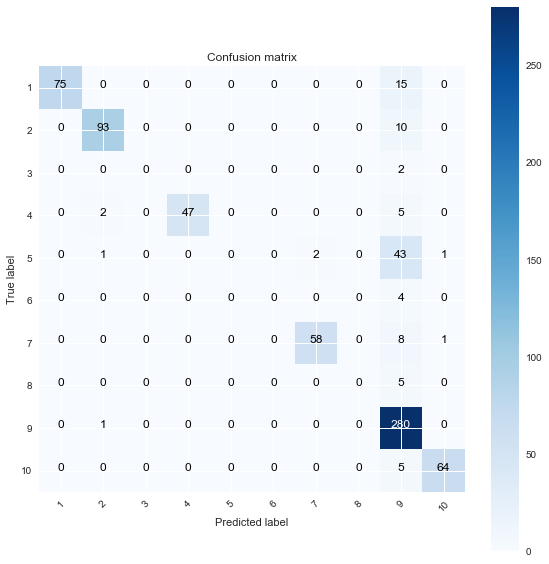

In [104]:
class_names = [i for i in range(1,11)]
cnf = confusion_matrix(Y_test, svc.predictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

In [105]:
# Code from sklearn documentation.
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number o

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number o

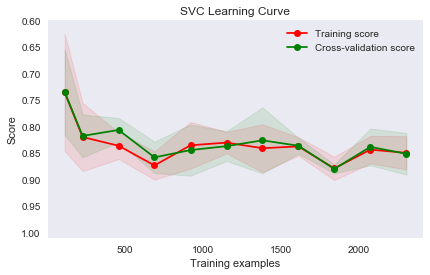

In [106]:
g = plot_learning_curve(svc.grid.best_estimator_, "SVC Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Logistics Regression :

In [107]:
from sklearn.linear_model import LogisticRegression

In [110]:
lr = Class_Fit(clf = LogisticRegression)
lr.grid_search(parameters = [{'C':np.logspace(-1,2,10)}], Kfold = 5)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lr.grid_fit(X_train, Y_train)

with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    lr.grid_predict(X_test, Y_test)

Precision: 88.37 %


Confusion matrix, without normalization
[[ 78   0   0   0   0   0   0   0  12   0]
 [  0  98   0   0   0   0   0   0   5   0]
 [  0   0   0   0   2   0   0   0   0   0]
 [  0   2   0  47   0   0   0   0   4   1]
 [  0   1   0   0  16   0   2   0  27   1]
 [  0   0   0   0   4   0   0   0   0   0]
 [  0   0   0   1   0   0  57   0   7   2]
 [  0   0   0   0   0   0   1   0   4   0]
 [  0   3   0   0   0   0   0   0 277   1]
 [  1   0   0   0   0   0   0   0   3  65]]


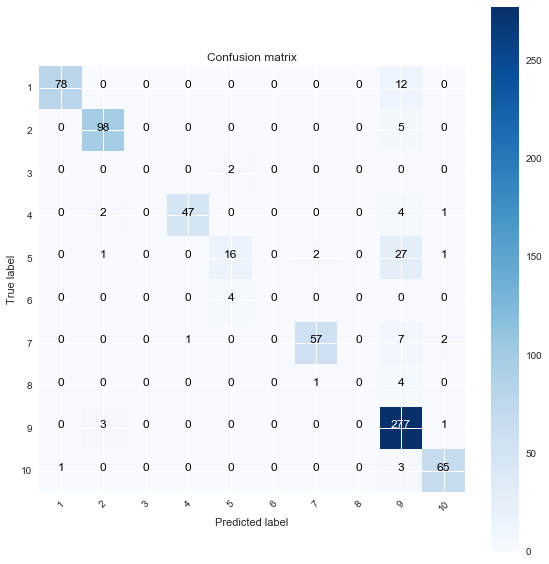

In [111]:
cnf = confusion_matrix(Y_test, lr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_mod

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_mod

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_mod

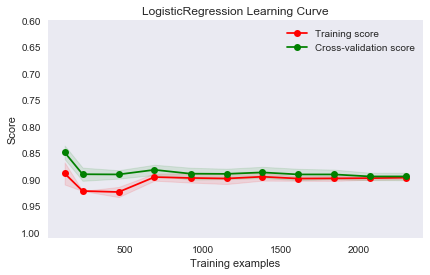

In [112]:
g = plot_learning_curve(lr.grid.best_estimator_, "LogisticRegression Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### K-Nearest Neighbours :

In [113]:
from sklearn.neighbors import KNeighborsClassifier

In [114]:
knn = Class_Fit(clf = KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors':np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X_train, Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 82.13 %


Confusion matrix, without normalization
[[ 73   0   0   0   1   0   0   0  15   1]
 [  1  88   0   1   0   0   0   0  13   0]
 [  0   0   0   0   1   1   0   0   0   0]
 [  0   4   0  41   0   0   0   0   9   0]
 [  0   0   0   0  38   0   0   0   9   0]
 [  0   0   1   0   0   3   0   0   0   0]
 [  1   0   0   0   5   0  42   0  17   2]
 [  0   0   0   0   1   0   0   0   4   0]
 [  5   3   0   1   7   0   1   0 262   2]
 [  4   1   0   0   0   0   0   0  18  46]]


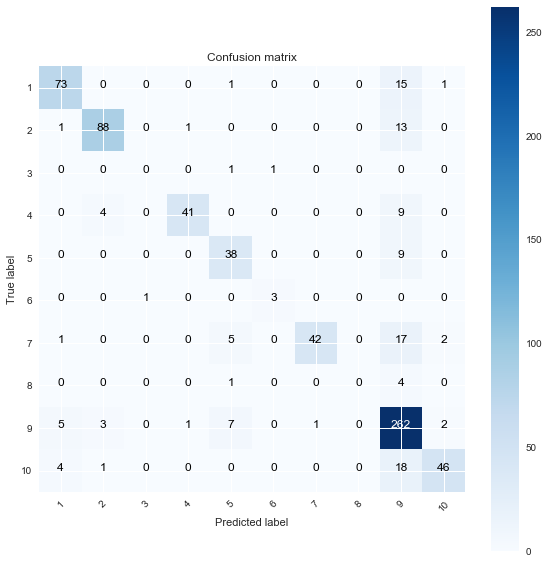

In [115]:
cnf = confusion_matrix(Y_test, knn.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

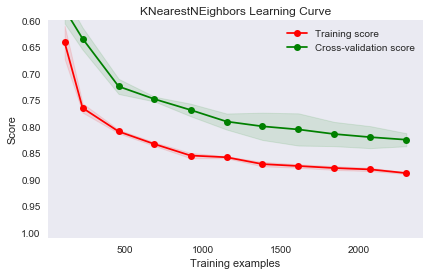

In [116]:
g = plot_learning_curve(knn.grid.best_estimator_, "KNearestNEighbors Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Decision Trees :

In [117]:
from sklearn.tree import DecisionTreeClassifier

In [118]:
tr = Class_Fit(clf = DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion':['entropy', 'gini'], 'max_features':['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X_train, Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 88.64 %


Confusion matrix, without normalization
[[ 82   0   0   0   0   0   0   0   8   0]
 [  1  95   0   0   0   0   0   0   7   0]
 [  0   0   0   0   2   0   0   0   0   0]
 [  0   2   0  48   1   0   1   0   2   0]
 [  0   0   0   1  26   1   1   0  17   1]
 [  0   0   0   0   3   1   0   0   0   0]
 [  0   0   0   0   3   1  58   1   3   1]
 [  0   0   0   0   0   0   1   0   4   0]
 [  4   1   0   1   7   0   1   2 263   2]
 [  1   0   0   0   0   0   1   0   0  67]]


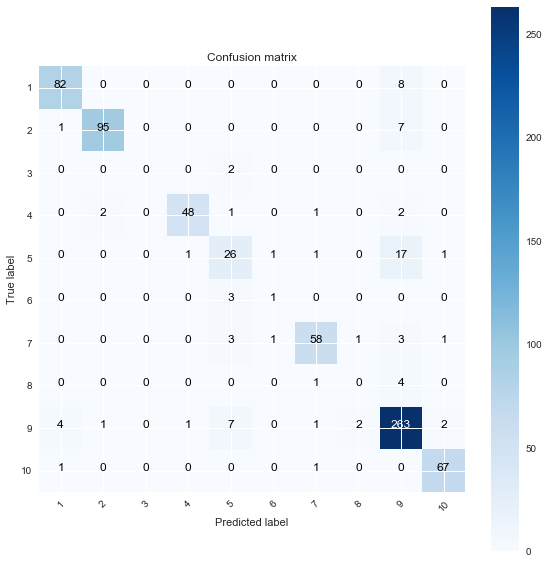

In [119]:
cnf = confusion_matrix(Y_test, tr.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

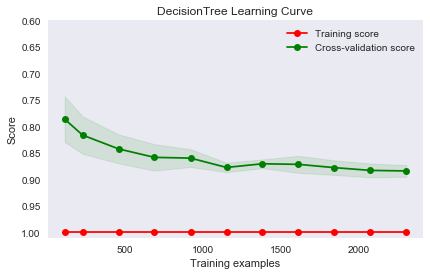

In [120]:
g = plot_learning_curve(tr.grid.best_estimator_, "DecisionTree Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Random Forests:

In [121]:
from sklearn.ensemble import RandomForestClassifier

In [122]:
rf = Class_Fit(clf = RandomForestClassifier)
rf.grid_search(parameters = [{'criterion':['entropy', 'gini'], 
                              'max_features':['sqrt', 'log2'], 'n_estimators':[20, 40, 60, 80, 100]}], Kfold = 5)
rf.grid_fit(X_train, Y_train)
rf.grid_predict(X_test, Y_test)

Precision: 92.11 %


Confusion matrix, without normalization
[[ 86   0   0   0   0   0   0   0   4   0]
 [  0  96   0   0   0   0   0   0   7   0]
 [  0   0   0   0   1   1   0   0   0   0]
 [  0   2   0  49   0   0   1   0   2   0]
 [  0   1   0   0  34   0   1   0  10   1]
 [  0   0   1   0   3   0   0   0   0   0]
 [  0   0   0   0   1   0  64   0   2   0]
 [  0   0   0   0   1   0   1   0   3   0]
 [  2   2   0   0   6   0   0   1 269   1]
 [  0   1   0   0   0   0   1   0   0  67]]


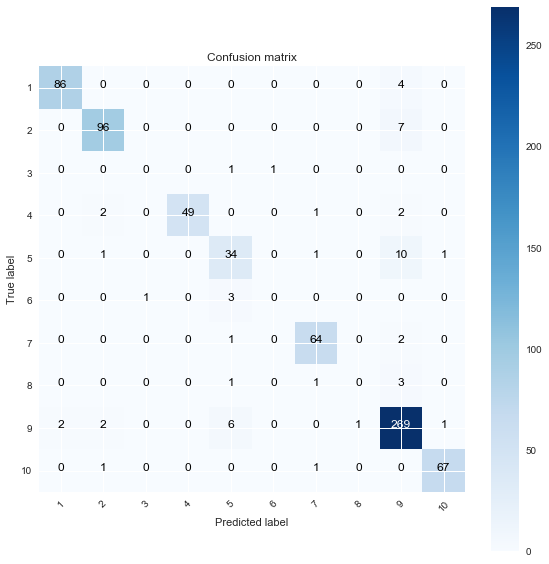

In [123]:
cnf = confusion_matrix(Y_test, rf.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

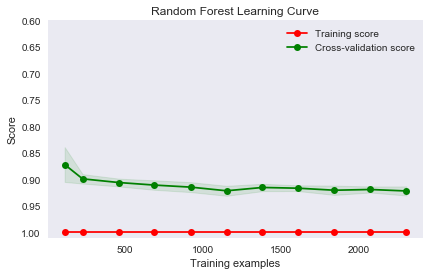

In [124]:
g = plot_learning_curve(rf.grid.best_estimator_, "Random Forest Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

In [125]:
from sklearn.ensemble import AdaBoostClassifier

In [126]:
ada = Class_Fit(clf = AdaBoostClassifier)
ada.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
ada.grid_fit(X_train, Y_train)
ada.grid_predict(X_test, Y_test)

Precision: 51.66 %


Confusion matrix, without normalization
[[  0   0   0   0   0   0   0   0  90   0]
 [  0  94   0   0   0   0   0   0   9   0]
 [  0   0   1   0   1   0   0   0   0   0]
 [  0  52   0   0   0   0   0   0   2   0]
 [  0   6   4   0   0   0   0   0  37   0]
 [  0   0   4   0   0   0   0   0   0   0]
 [  0   2   0   0   0   0   0   0  65   0]
 [  0   0   0   0   0   0   0   0   5   0]
 [  0   3   0   0   0   0   0   0 278   0]
 [  0   1   0   0   0   0   0   0  68   0]]


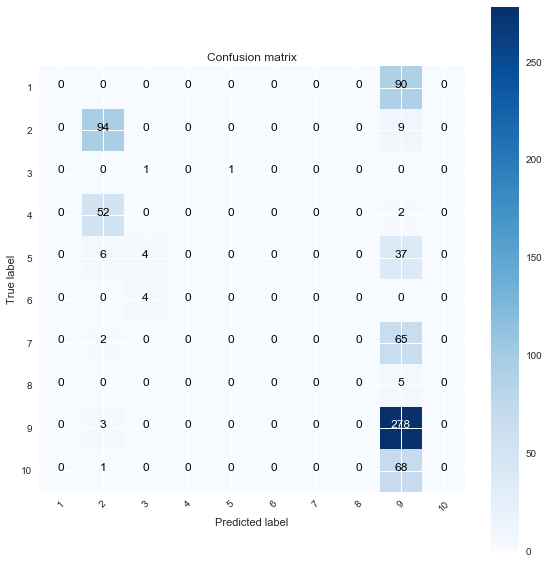

In [127]:
cnf = confusion_matrix(Y_test, ada.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

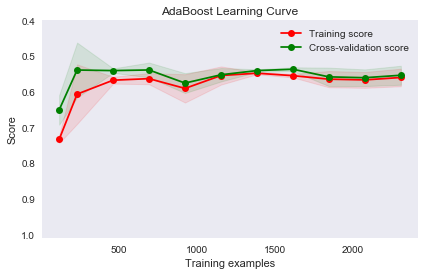

In [128]:
g = plot_learning_curve(ada.grid.best_estimator_, "AdaBoost Learning Curve", X_train, Y_train, ylim=[1.01, 0.4], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Gradient Boosted Decision Trees :

In [130]:
import xgboost

In [131]:
gbdt = Class_Fit(clf = xgboost.XGBClassifier)
gbdt.grid_search(parameters = [{'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}], Kfold = 5)
gbdt.grid_fit(X_train, Y_train)
gbdt.grid_predict(X_test, Y_test)

Precision: 92.66 %


Confusion matrix, without normalization
[[ 86   0   0   0   0   0   0   0   4   0]
 [  0  96   0   0   0   0   0   0   7   0]
 [  0   0   0   0   1   1   0   0   0   0]
 [  0   2   0  49   0   0   1   0   2   0]
 [  1   0   0   0  35   0   0   0  10   1]
 [  0   0   1   0   0   2   1   0   0   0]
 [  0   0   0   0   2   0  63   0   2   0]
 [  0   0   0   0   1   0   1   0   3   0]
 [  2   2   0   0   6   0   0   0 270   1]
 [  0   0   0   0   0   0   0   0   1  68]]


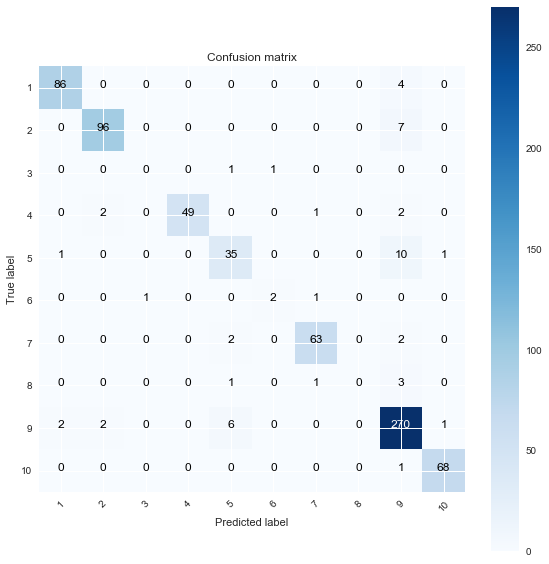

In [132]:
cnf = confusion_matrix(Y_test, gbdt.predictions)
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf, class_names)

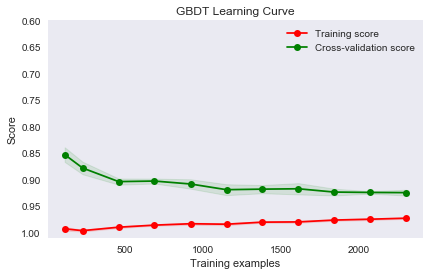

In [133]:
g = plot_learning_curve(gbdt.grid.best_estimator_, "GBDT Learning Curve", X_train, Y_train, ylim=[1.01, 0.6], cv = 5,
                        train_sizes = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

#### Voting Classifier :

In [134]:
rf_best = RandomForestClassifier(**rf.grid.best_params_)
gbdt_best = xgboost.XGBClassifier(**gbdt.grid.best_params_)
svc_best = LinearSVC(**svc.grid.best_params_)
tr_best = DecisionTreeClassifier(**tr.grid.best_params_)
knn_best = KNeighborsClassifier(**knn.grid.best_params_)
lr_best = LogisticRegression(**lr.grid.best_params_)

In [135]:
from sklearn.ensemble import VotingClassifier

In [136]:
votingC = VotingClassifier(estimators=[('rf', rf_best), ('gb', gbdt_best), ('knn', knn_best), ('lr', lr_best)])

In [137]:
votingC = votingC.fit(X_train, Y_train)

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [138]:
predictions = votingC.predict(X_test)

In [139]:
print("Precision : {:.2f}%".format(100 * accuracy_score(Y_test, predictions)))

Precision : 92.24%


> This is the highest precision that we have obtained.

### Testing the model :

In [140]:
basket_price = set_test.copy(deep=True)

In [141]:
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100
    
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()

transanctions_per_user['count'] = 5 * transanctions_per_user['count']
transanctions_per_user['sum'] = transanctions_per_user['count'] * transanctions_per_user['mean']

transanctions_per_user.sort_values('CustomerID', ascending = True)[:5]

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,10,224.82,1294.32,759.57,7595.70,12.696657,24.271627,37.379043,5.634767,20.017905
1,12349.0,5,1757.55,1757.55,1757.55,8787.75,4.513101,10.713778,37.877728,20.389178,26.506216
2,12352.0,5,311.73,311.73,311.73,1558.65,6.672441,7.217785,34.398358,17.290604,34.420813
3,12356.0,5,58.35,58.35,58.35,291.75,0.000000,0.000000,100.000000,0.000000,0.000000
4,12357.0,5,6207.67,6207.67,6207.67,31038.35,5.089832,28.350089,22.895547,25.189000,18.475531


In [142]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
matrix_test = transanctions_per_user[list_cols].as_matrix()
scaled_test_matrix = scaler.transform(matrix_test)

C:\Users\ahari\Anaconda3\anaconda\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [143]:
Y = kmeans.predict(scaled_test_matrix)
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = transanctions_per_user[columns]
predictions = votingC.predict(X)

In [144]:
print("Precision : {:.2f}%".format(100 * accuracy_score(Y, predictions)))

Precision : 88.59%


> Accuracy on test dataset is good considering we use 10 months old data to predict on new data.